# Overview

- Kiểm tra dữ liệu bị trùng lặp

- Kiểm tra xữ liệu bị missing trừ cột attribute_time

Notebook này có 2 phần chính:

**Phân tích tập mẫu 10 triệu rows đầu tiên**

    - Số lượng các giá trị unique của mỗi feature
    
    - Tỉ lệ số lần app được download
    
    - Conversion tỉ lệ download trên tổng số lần click của mỗi feature
    
    - Phân tích dữ liệu về ip
    
**Phân tích dữ liệu thời gian**

    - Thời gian thu thập dữ liệu
    
    - Tỉ lệ app được download theo giờ
    
    - Thời gian app được download sau khi được click ad

This competition is a **binary classification** problem - i.e. our target variable is a binary attribute (Is the user making the click fraudlent or not?) and our goal is to classify users into "fraudlent" or "not fraudlent" as well as possible

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
import subprocess
from utils1 import UnivariateAnalysis, StatisticAnalysis, BivariateAnalysis

#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

<Figure size 1200x500 with 0 Axes>

### Data overview

In [19]:
def check_fsize(dpath,s=30):
    """check file size
    Args:
    dpath: file directory
    s: string length in total after padding
    
    Returns:
    None
    """
    for f in os.listdir(dpath):
        print(f.ljust(s) + str(round(os.path.getsize(dpath+'/' + f) / 1000000, 2)) + 'MB')

In [20]:
check_fsize(r"C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection")

sample_submission.csv         195.58MB
test.csv                      863.27MB
test_supplement.csv           2665.54MB
train.csv                     7537.65MB
train_sample.csv              4.08MB


In [21]:
def check_fline(fpath):
    """check total number of lines of file for large files
    
    Args:
    fpath: string. file path
    
    Returns:
    None
    
    """
    lines = subprocess.run(['wc', '-l', fpath], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

In [22]:
# fs=[r'C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection\train.csv', r'C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection\test.csv', r'C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection\train_sample.csv']
# [check_fline(s) for s in fs]

That makes 185 million rows in the training set and ** 19 million** in the test set. Handily the organisers have provided a train_sample.csv which contains 100K rows in case you don't want to download the full data. In this case, i will work with train_sample and test sample

In [3]:
#import first 10,000,000 rows of train and all test data
train = pd.read_csv(r'C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection\train_sample.csv', nrows=10000000)
test = pd.read_csv(r'C:\Users\swift\Downloads\talkingdata-adtracking-fraud-detection\test_sample.csv')

In [24]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [26]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### Looking at the columns

According to the data page, our data contains:

* `ip`: ip address of click
* `app`: app id for marketing
* `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* `os`: os version id of user mobile phone
* `channel`: channel id of mobile ad publisher
* `click_time`: timestamp of click (UTC)
* `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
* `is_attributed`: the target that is to be predicted, indicating the app was downloaded

**A few things of note:**
* If you look at the data samples above, you'll notice that all these variables are encoded - meaning we don't know what the actual value corresponds to - each value has instead been assigned an ID which we're given. This has likely been done because data such as IP addresses are sensitive, although it does unfortunately reduce the amount of feature engineering we can do on these.
* The `attributed_time` variable is only available in the training set - it's not immediately useful for classification but it could be used for some interesting analysis (for example, one could fill in the variable in the test set by building a model to predict it).
* Chúng ta có thể quan sát rằng giá trị của attributed_time là NaN. Đặc điểm attributed_time sẽ có giá trị NaN đối với người dùng chưa tải ứng dụng sau khi nhấp vào quảng cáo ứng dụng (is_attributed = 0), và attributed_time sẽ có giá trị thời gian tương tự như click_time đối với người dùng đã tải ứng dụng sau khi nhấp vào quảng cáo ứng dụng (is_attribute = 1).


In [27]:
# checking for the duplicated rows
sum(train.duplicated(subset = list(train.columns)))

221295

This could contribute to count features working so well, if these are bot-generated. All of them capture these duplicates.

On the other hand, it could just be a logging issue as well, depending on how they aggregate their logs.

ip                       0
app                      0
device                   0
os                       0
channel                  0
click_time               0
attributed_time    9981283
is_attributed            0
dtype: int64


c:\Users\swift\dean\Click-fraud-cascaded-forest\utils1.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_df['null_percentage'], y=null_df['feature'], palette=custom_palette, saturation=1,


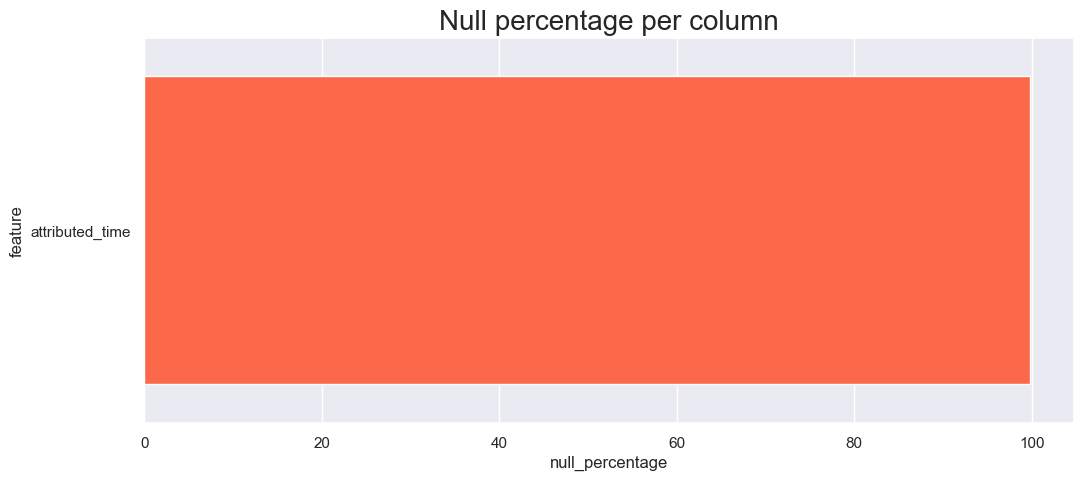

In [28]:
# Check for null values in all columns except 'attributed_time'
# columns_to_check = train.columns.difference(["attributed_time"])
# null_counts = train[columns_to_check].isnull().sum()

# print(null_counts)
stat_analysis = StatisticAnalysis(train)
stat_analysis.check_null()

No columns have null values beside the "attributed_time" column. 

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 610.4+ MB


ip, app, device, os and channel are actually categorical variables encoded as integers.   Set them as categories for analysis.

In [18]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

Convert date stamps to date/time type.

In [22]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
train['click_hour']=train['click_time'].dt.hour
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

Now lets do a quick inspection of train and test data main statistics

*this graph is adapted from https://www.kaggle.com/anokas/talkingdata-adtracking-eda*:

### Table 1: Số lượng giá trị unique của mỗi feature

In [32]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1000x600 with 0 Axes>

Quick check to make sure that Nan values in 'attribute_time' are only for samples that did not convert. Check that counts of 'attributed_time' values is same as count of converted clicks.

In [33]:
#double check that 'attributed_time' is not Null for all values that resulted in download (i.e. is_attributed == 1)
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time
count,18717
mean,2017-11-07 00:10:04.718064128
min,2017-11-06 16:00:47
25%,2017-11-06 19:59:39
50%,2017-11-06 23:34:47
75%,2017-11-07 02:40:27
max,2017-11-07 15:59:53


In [34]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_time
count,18790469
mean,2017-11-10 09:43:00.548308480
min,2017-11-10 04:00:00
25%,2017-11-10 05:27:21
50%,2017-11-10 10:03:52
75%,2017-11-10 13:34:07
max,2017-11-10 15:00:00


###UNIVARIATE ANALYSIS

count     10000000
unique         332
top             12
freq       1291185
Name: app, dtype: int64


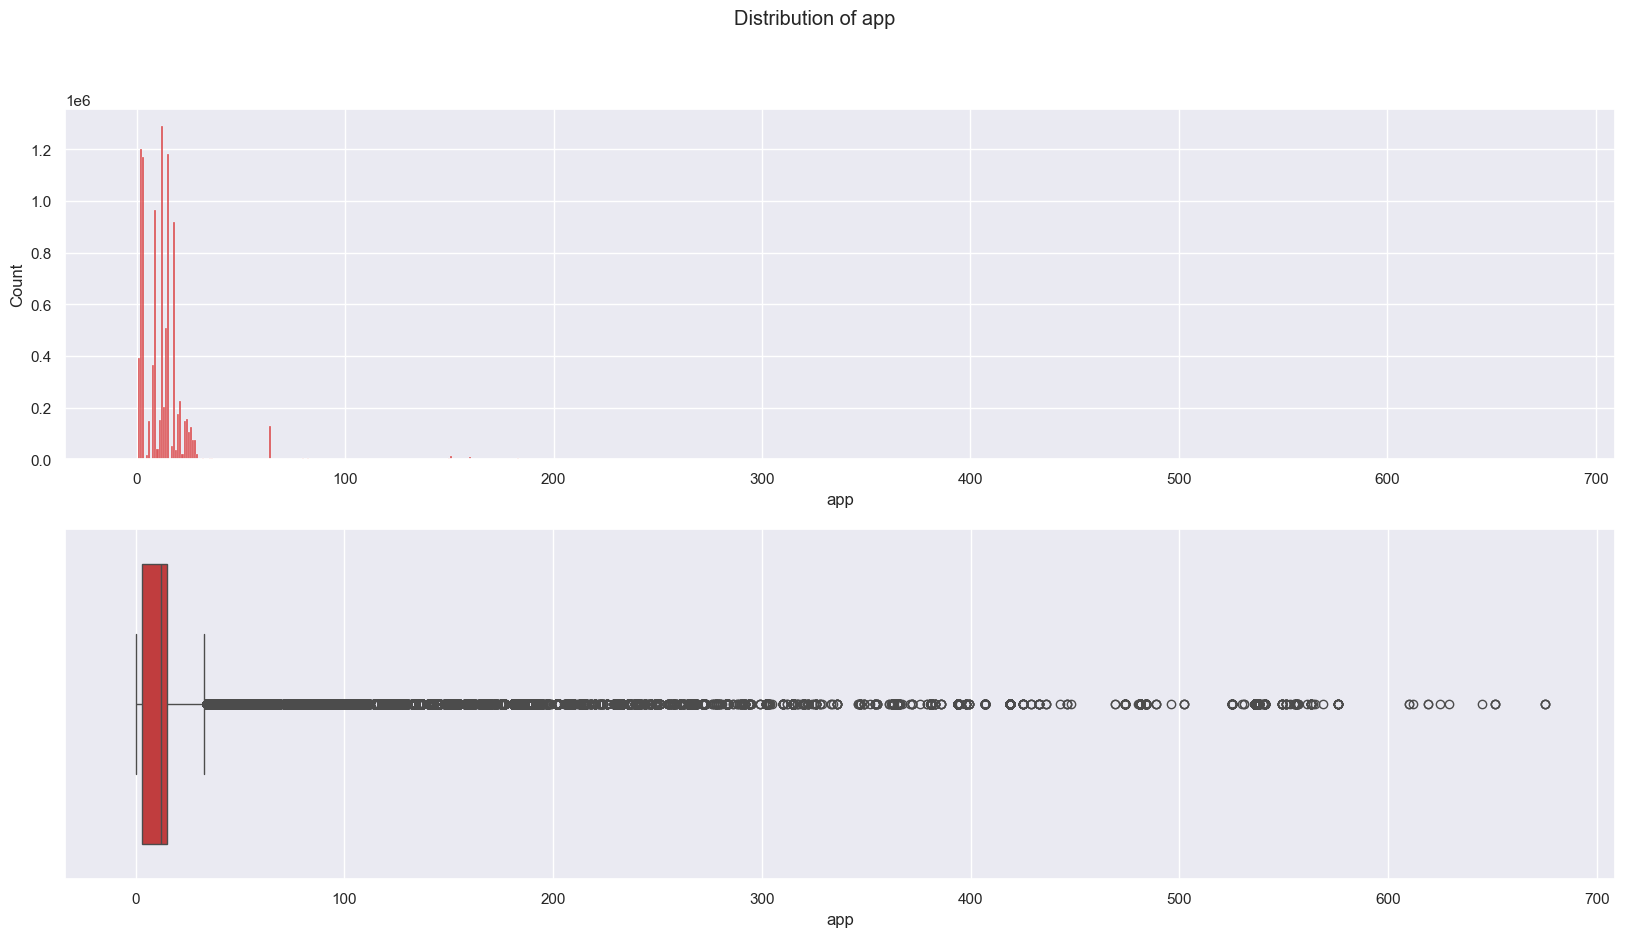

In [28]:
univariate_train = UnivariateAnalysis(train)
univariate_train.visualize_numeric(x='app')

count     10000000
unique       68740
top          73516
freq         51711
Name: ip, dtype: int64


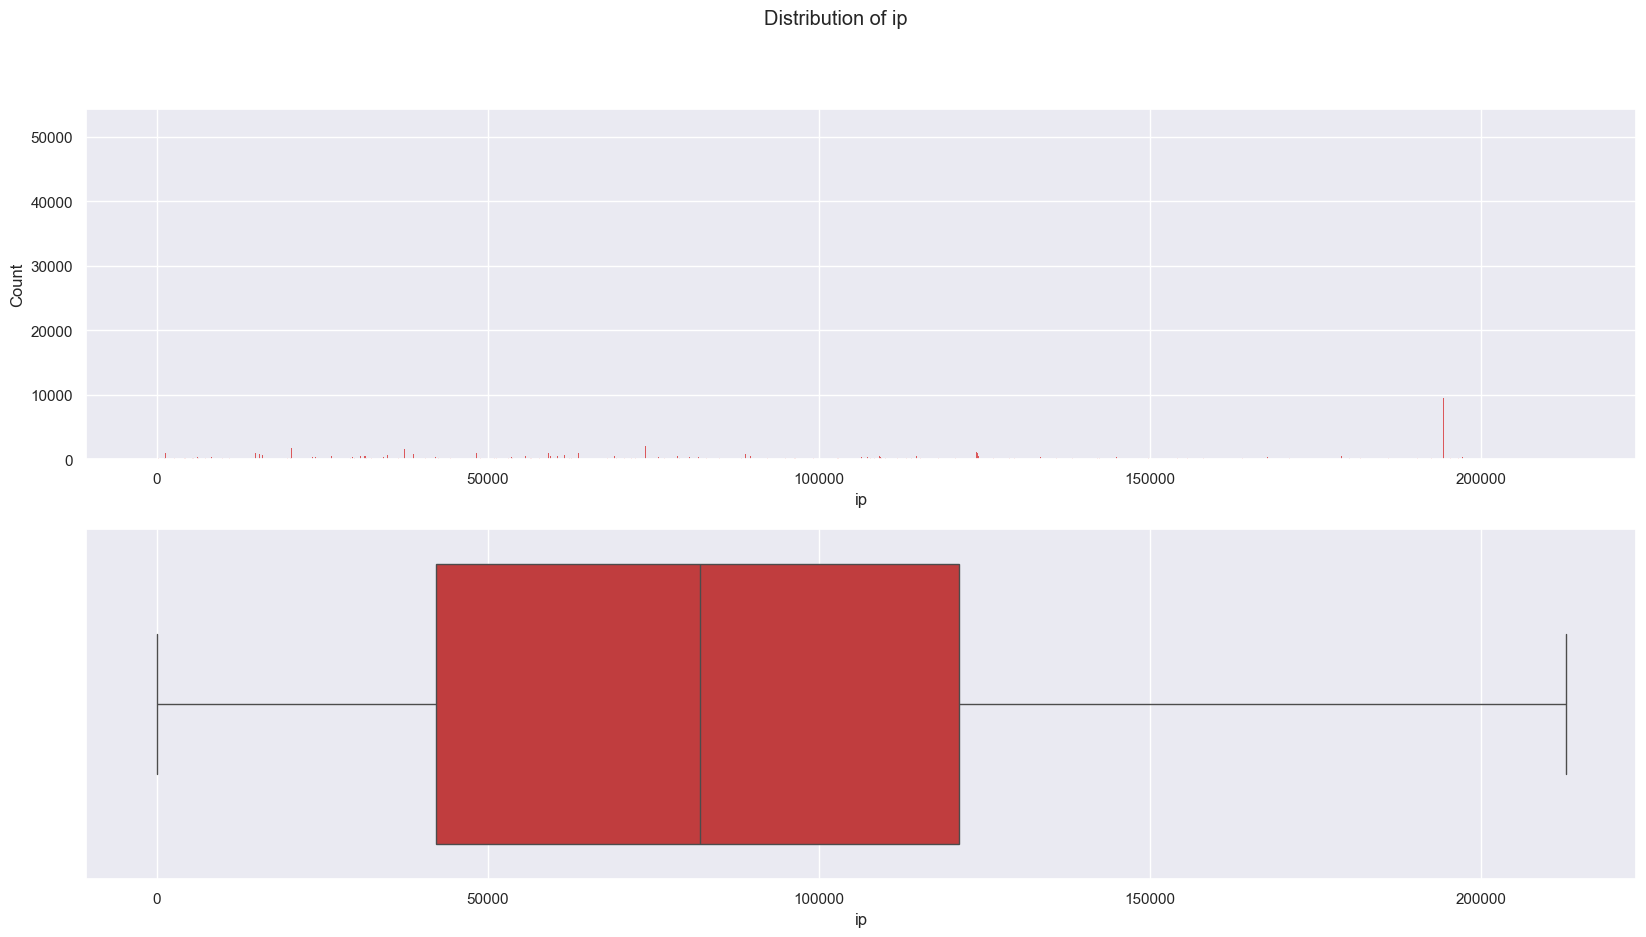

In [41]:
univariate_train.visualize_numeric(x='ip')

count     10000000
unique         940
top              1
freq       9381146
Name: device, dtype: int64


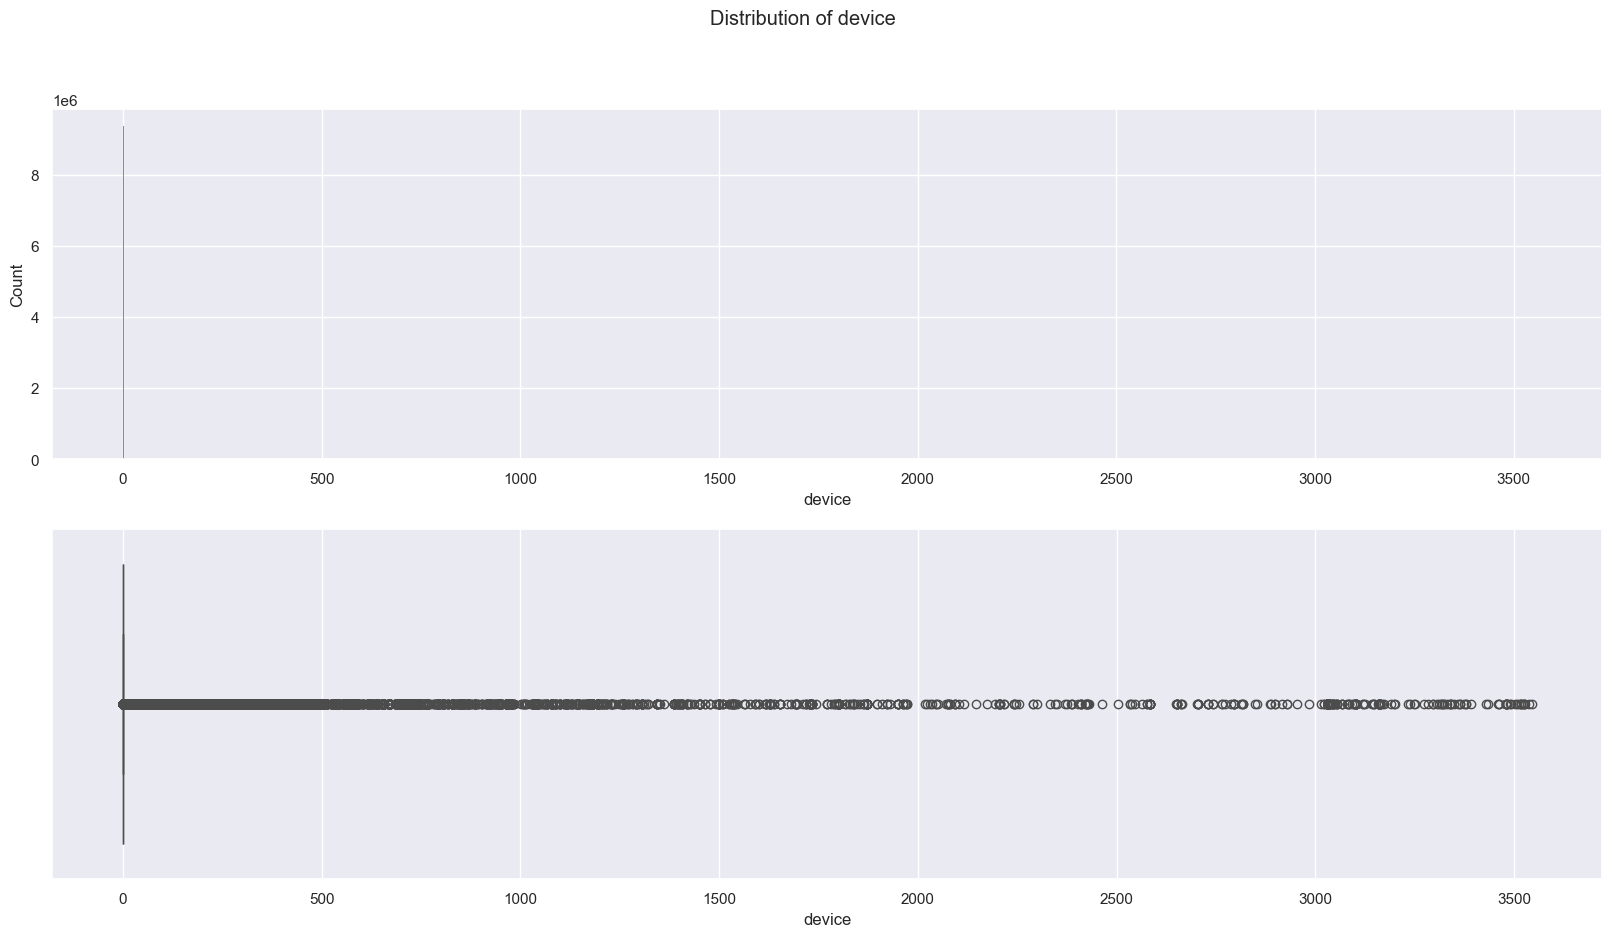

In [31]:
univariate_train.visualize_numeric(x='device')

count     10000000
unique         292
top             19
freq       2410148
Name: os, dtype: int64


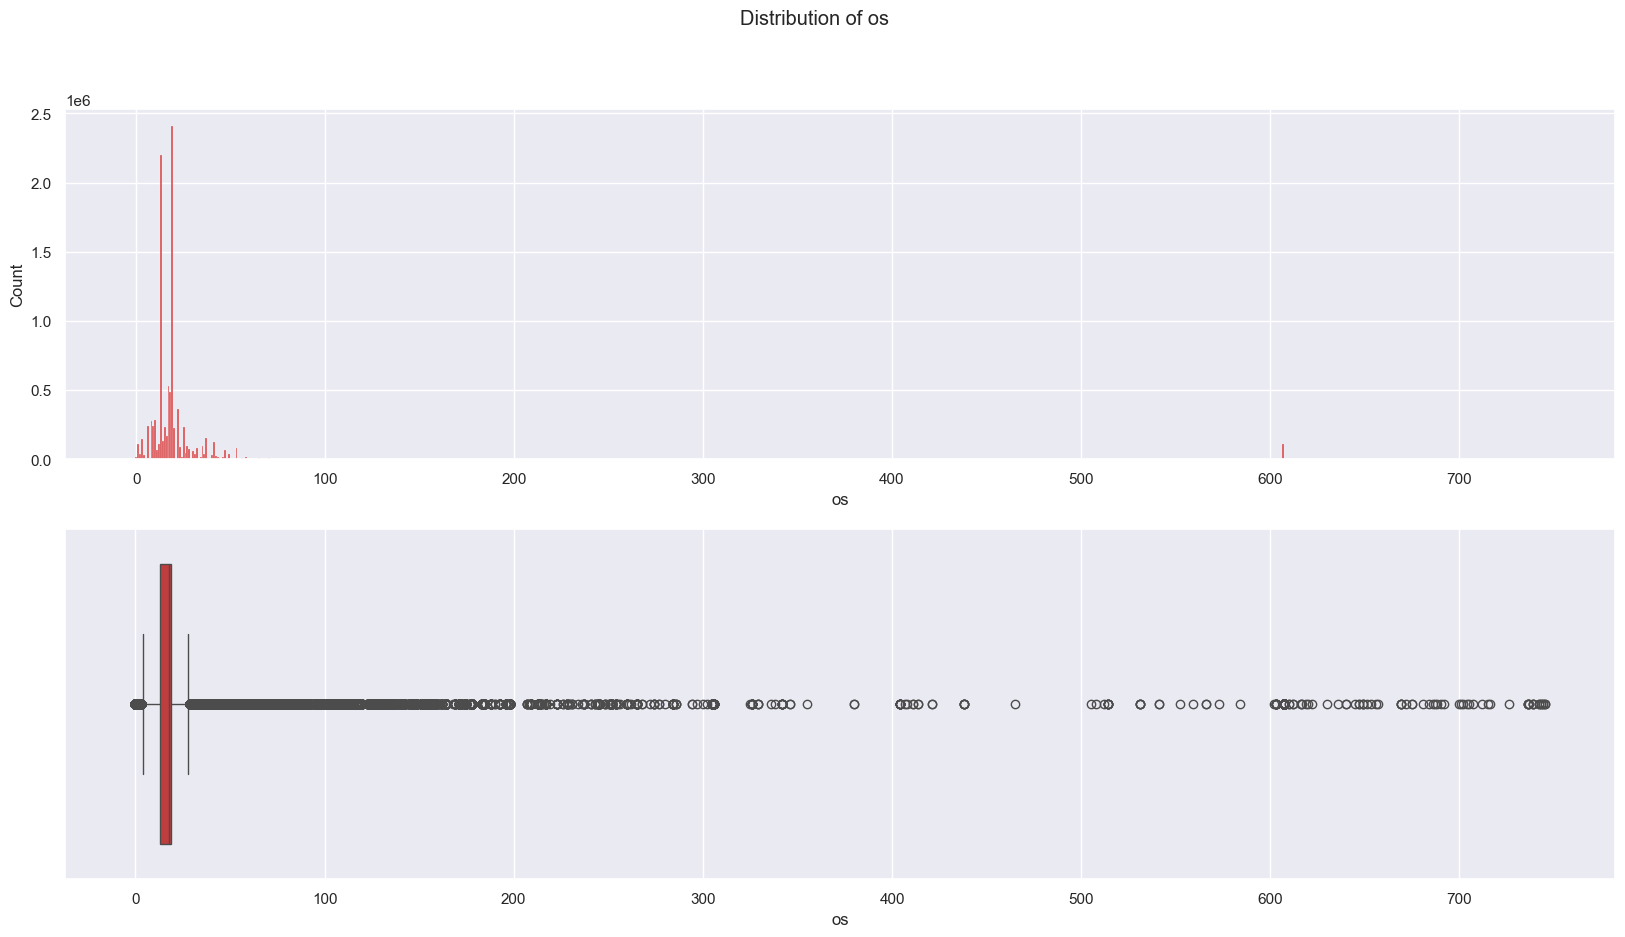

In [30]:
univariate_train.visualize_numeric(x='os')

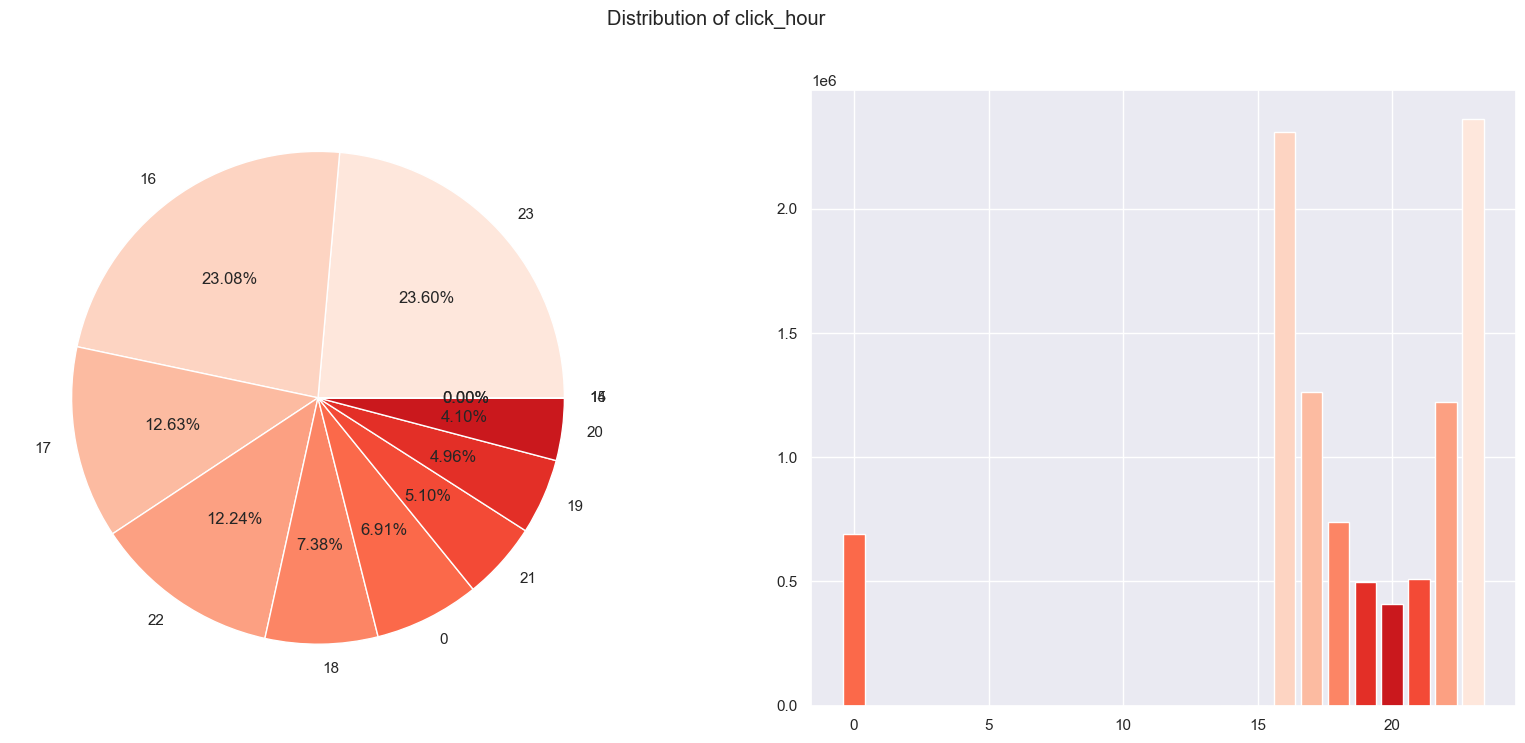

In [35]:
univariate_train.visualize(x='click_hour')

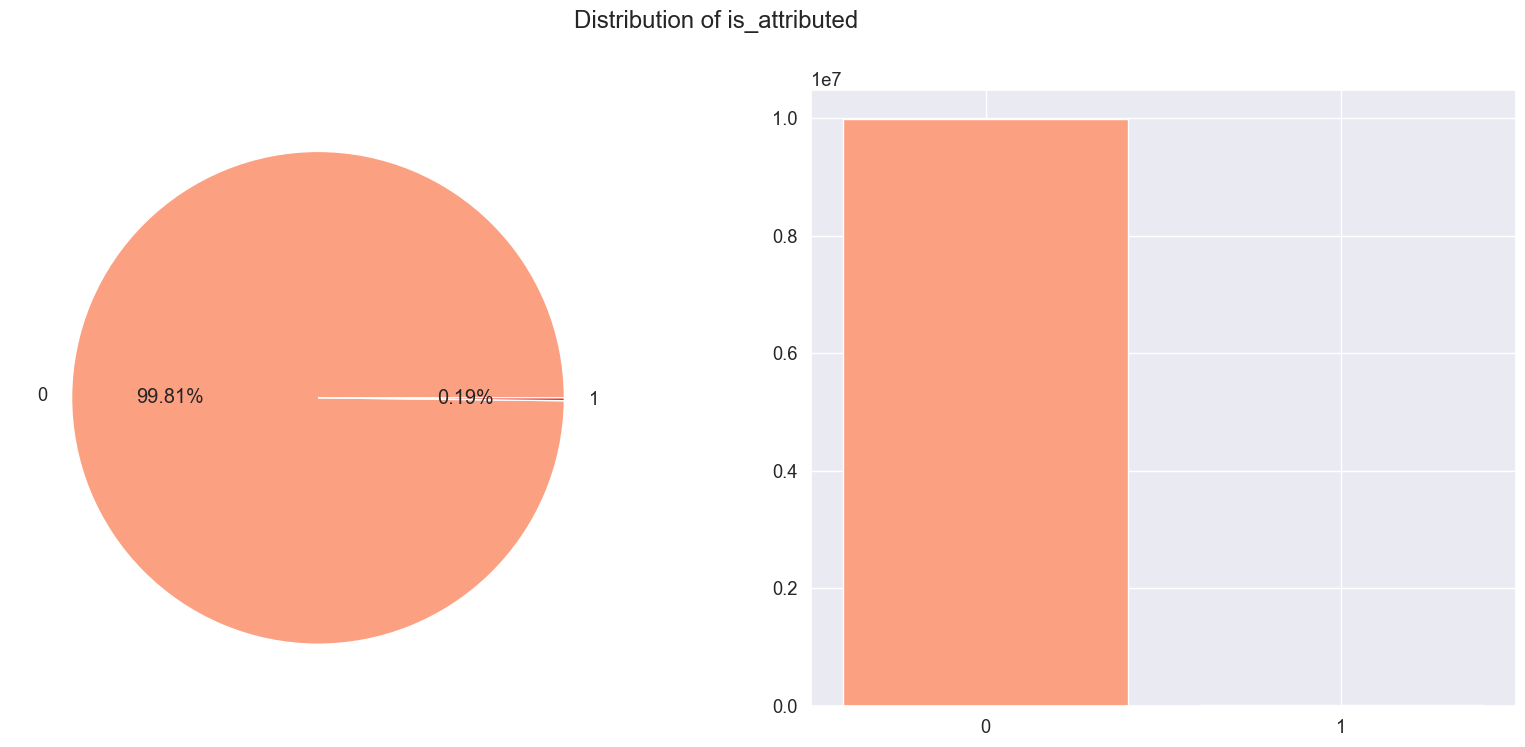

In [ ]:
univariate_train.visualize(x='is_attributed')

Only a small proportion of clicks were followed by a download.We can see that the dataset is highly imbalance.:

# Bivariate Analysis

### Explore ip counts.  Check if multiple ips have any downloads.

At this point I was trying to figure out what 'ip' were actually encoding.  My original understanding that ips were user specific did not hold up to scrutiny.
If ip repeated too many times, was it a bot?  This does not appear to be true, as repeated ips do convert.  See below:

In [ ]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [ ]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

In [ ]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


In [ ]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

So high frequency ip counts do get conversions. Up to 56 downloads for one ip (ip 73487). Each IP must be for some network with many devices. From what I found, some ip's got huge amount of clicks are mostly likely, I think, a publicly accessible free wifi while ip's got only a few clicks are likely resident ip.

In [ ]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

**Nhận xét** :
- Có 18717 attributed_time values.  Điều đó có nghĩa là chỉ 18, 717 trong tổng số 10,000,000 clicks là có download. Chiếm tỉ lệ thấp hơn 0.2% !. Từ đó kết luận dataset này highly imbalance. 
- Có những ip được click hơn 50 nghìn lần. Dường như lạ khi một địa chỉ IP lại nhấp chuột rất nhiều lần trong khoảng thời gian chỉ là 4 ngày. Điều này có nghĩa là địa chỉ IP đã được mã hóa không phải là ID thiết bị mà có lẽ là ID mạng? (đã khám phá điều này bên trên). Giải thiết được đưa ra là nhiều thiết bị cùng sử dụn 1 địa chỉ IP. 
- Click  đầu tiên trong bộ dữ liệu huấn luyện (train) là vào lúc 14:32:21 ngày 06/11/2017. Các click trong bộ dữ liệu kiểm thử (test) bắt đầu vào ngày 10/11/2017. Dựa trên thông số dữ liệu, bộ dữ liệu huấn luyện bao gồm một khoảng thời gian là 4 ngày. Điều này có nghĩa là dữ liệu huấn luyện và dữ liệu kiểm thử không trùng nhau, nhưng dữ liệu kiểm thử bắt đầu vào ngày ngay sau khi kết thúc dữ liệu huấn luyện
- Ngày 06/11/2017 là một ngày Thứ Hai. Ngày 10/11/2017 là một ngày Thứ Sáu. Nói cách khác, dữ liệu huấn luyện là từ Thứ Hai đến Thứ Năm, còn dữ liệu kiểm thử là Thứ Sáu.
- Dữ liệu huấn luyện được sắp xếp theo thời gian (timestamp). (do đó, các batch được trích xuất theo thứ tự chỉ bao phủ một khoảng thời gian hạn chế)
- Không có dữ liệu bị thiếu trong bộ kiểm thử. Giá trị thiếu trong bộ huấn luyện xuất hiện chỉ trong attributed_time, nơi không có giá trị do không có việc tải ứng dụng.

In [4]:
bivariate_train = BivariateAnalysis()

In [23]:
fraud = train[train['is_attributed']==1]
non_fraud = train[train['is_attributed']==0]

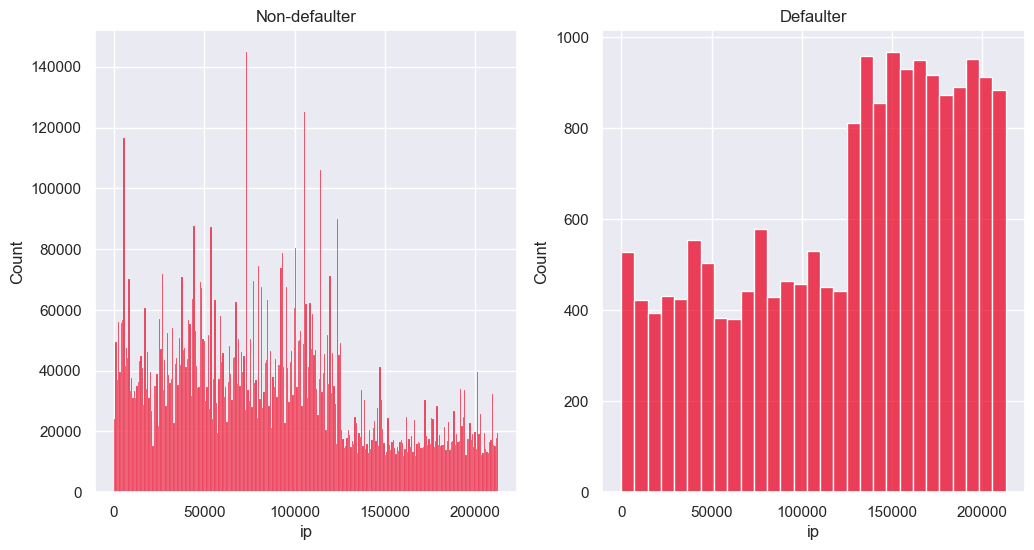

In [8]:
bivariate_train.hist_plot(x= 'ip', df1= non_fraud, df2 = fraud)

In [9]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

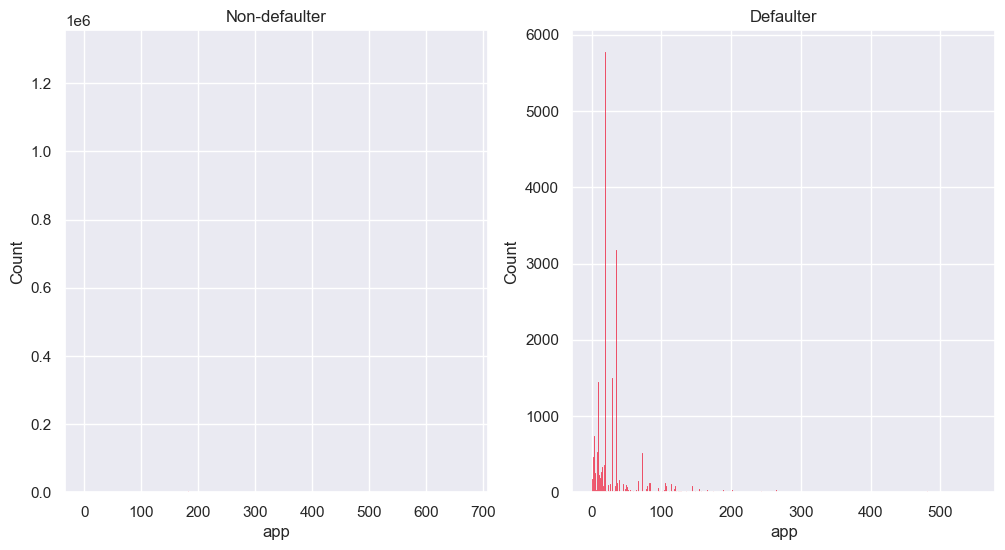

In [10]:
bivariate_train.hist_plot(x= 'app', df1= non_fraud, df2 = fraud)

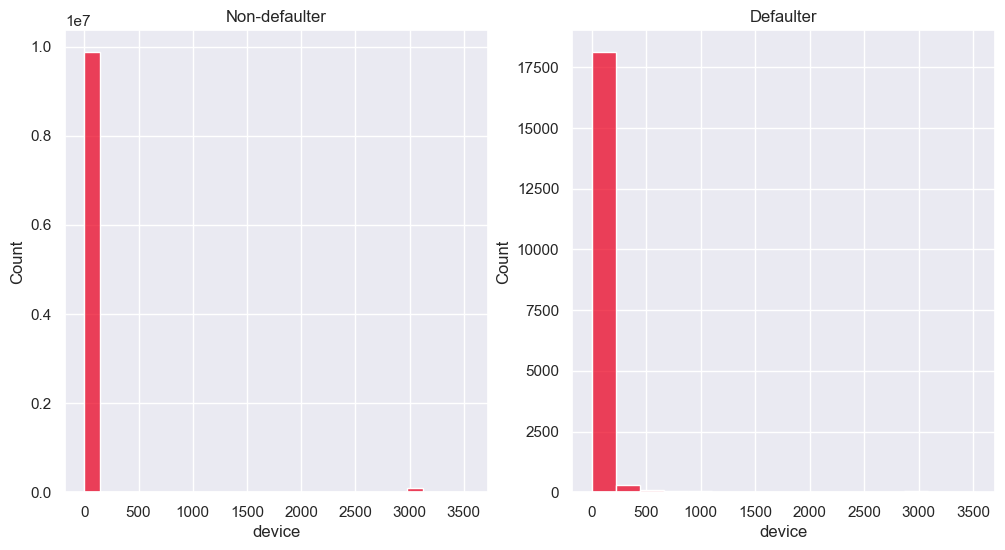

In [13]:
bivariate_train.hist_plot(x= 'device', df1= non_fraud, df2 = fraud)

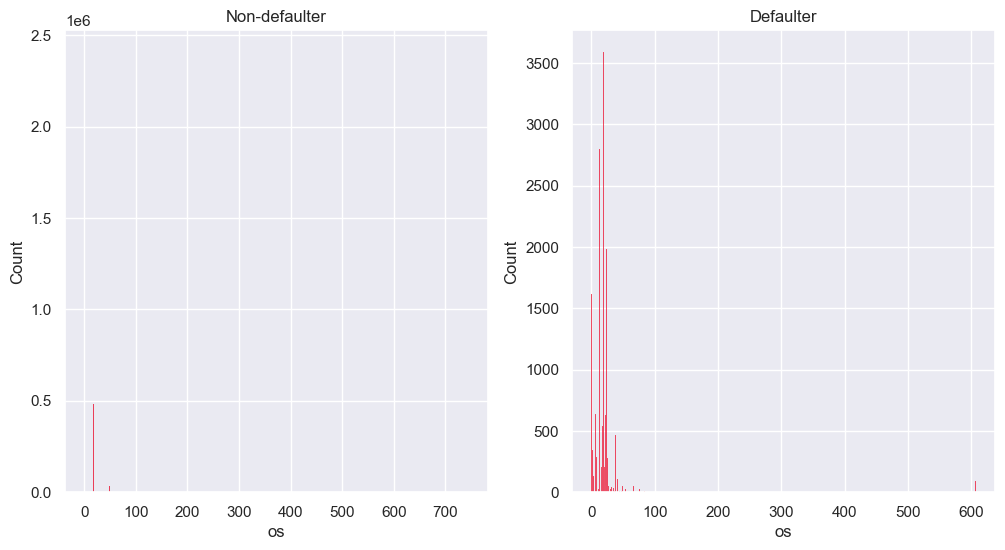

In [14]:
bivariate_train.hist_plot(x= 'os', df1= non_fraud, df2 = fraud)

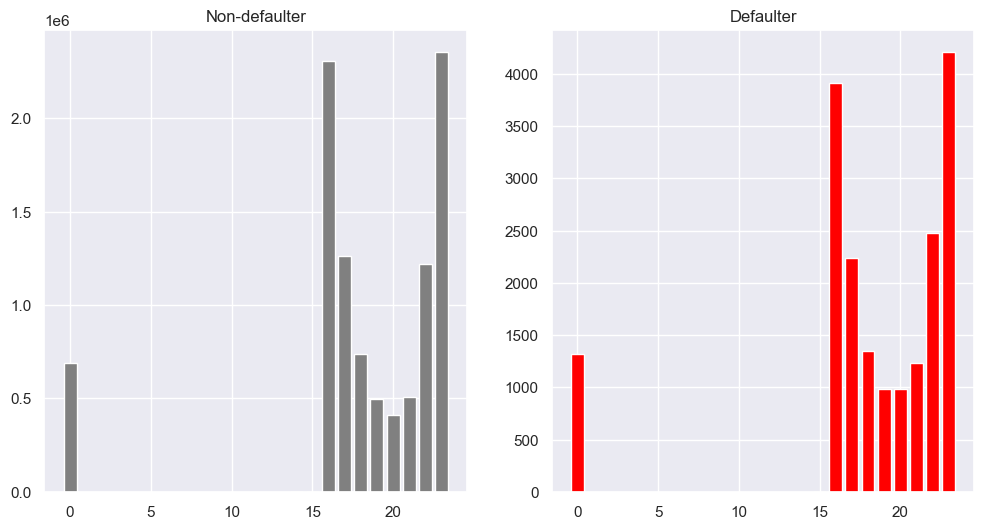

In [24]:
bivariate_train.bar_plot(x= 'click_hour', df1= non_fraud, df2 = fraud)

## Conversion feature

**Nhận xét chung: 
Nhìn chung mỗi feature đều có sự chênh lệch lớn về số lần click ad giữa các giá trị. Với các giá trị có số lần click cao, tỉ lệ app được tải giao động ở khoảng 0.0001-0.00015**

### Conversion rates over Counts of 300 most popular IPs

C:\Users\swift\AppData\Local\Temp\ipykernel_5812\1802565874.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
C:\Users\swift\AppData\Local\Temp\ipykernel_5812\1802565874.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)


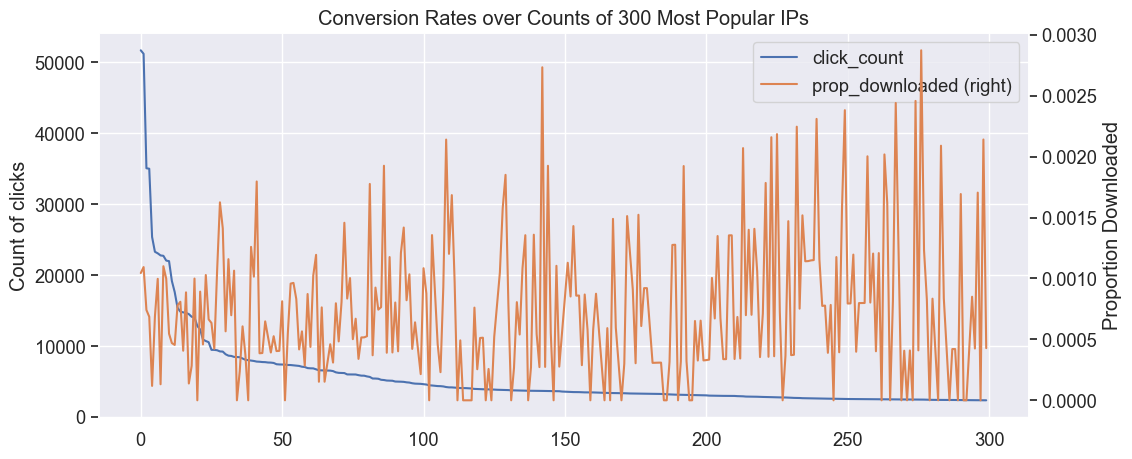



**************************************************
Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        51711         0.001044
1    73487        51215         0.001093
2     5314        35073         0.000741
3     5348        35004         0.000686
4    53454        25381         0.000118
5   105560        23289         0.000687
6   100275        23070         0.000997
7   114276        22774         0.000132
8   201182        22719         0.001100
9   105475        22047         0.000998
10   95766        21966         0.000546
11   26995        19166         0.000470
12  209663        17605         0.000454
13   43793        15398         0.000779
14  137052        14840         0.000809
15   86767        14742         0.000407
16   17149        14673         0.000886
17  111025        14493         0.000138
18  138561        14119         0.000283
19  147957        14012         0.000999


In [ ]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])


Conversions are noisy and do not appear to correlate with how popular an IP is.

### Conversions by App

Check 100 most popular apps by click count:

     app  is_attributed
207  246       1.000000
293  443       1.000000
284  395       1.000000
171  196       1.000000
109  116       0.882353
   app  is_attributed
12  12        1291185
2    2        1202534
15  15        1181585
3    3        1170412
9    9         966839


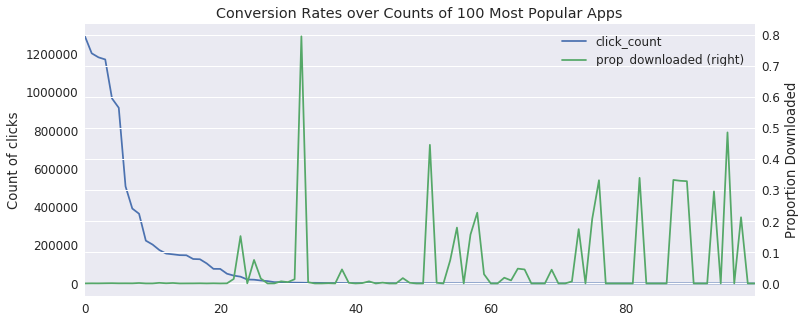



**************************************************
Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1291185         0.000140
1    2      1202534         0.000388
2   15      1181585         0.000277
3    3      1170412         0.000630
4    9       966839         0.000869
5   18       917820         0.000397
6   14       507491         0.000483
7    1       391508         0.000350
8    8       364361         0.001441
9   21       223823         0.000089
10  13       203332         0.000103
11  20       174792         0.001962
12  24       156247         0.000550
13  11       152367         0.001503
14  23       148119         0.000027
15   6       147356         0.000176
16  64       127923         0.000258
17  26       126630         0.000537
18  25       104855         0.000095
19  27        76417         0.000523


In [ ]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
print(proportion.head())
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
print(counts.head())
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

There is a again a huge difference in clicks per app. Clicks per app vary widely, ranging from one to nearly 13 million. Proportions of clicks to counts are more sensitive to changes when counts are low. Apps with counts in the thousands generally maintain a stable ratio, staying within the 0.0001 to 0.0015 range. Less popular apps, with lower counts, exhibit greater fluctuation in the click-to-count ratio.

### Conversions by OS
Look at top 100 operating systems by click count

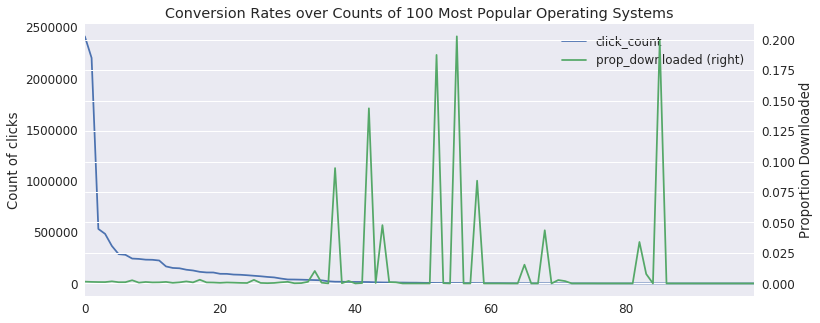



**************************************************
Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19      2410148         0.001489
1    13      2199778         0.001271
2    17       531695         0.001155
3    18       483602         0.001115
4    22       365576         0.001729
5    10       285907         0.001011
6     8       279549         0.001037
7     6       242799         0.002619
8     9       239377         0.000656
9    25       232143         0.001206
10   15       230832         0.000853
11   20       223820         0.000920
12   16       166165         0.001258
13   37       151274         0.000509
14    3       147970         0.000919
15   14       134127         0.001663
16   41       126565         0.000877
17    1       113395         0.003042
18  607       107442         0.000856
19   12       107005         0.000757


In [ ]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Same story. For values in the thousands the boundary on the ratio is very low, roughly between 0.0006 and 0.003, but as counts on OS become lower, the ratio starts fluxuating more wildely.

### Conversions by Device

Devices are extremely disproportionately distributed, with number one device used almost 94% of time.  For that device proportion download was 0.001356. (0.13%)

In [ ]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']
merge = merge.sort_values(by='click_count', ascending=False)

print('Count of clicks and proportion of downloads by device:')
print(merge[:20])

Count of clicks and proportion of downloads by device:
   device  click_count  prop_downloaded
0       1      9381146         0.001326
1       2       456617         0.000208
2    3032       104393         0.000000
3       0        46476         0.091961
4      59         1618         0.001236
5      40          462         0.246753
6       6          458         0.222707
7      16          334         0.242515
8      18          247         0.226721
9      33          204         0.196078
10     21          190         0.242105
11   3033          151         0.178808
12    154          151         0.178808
13     37          145         0.193103
14     30          126         0.301587
15     46          123         0.211382
16    114          122         0.172131
17      7          121         0.231405
18     88          117         0.324786
19    109          113         0.300885


### Conversions by Channel


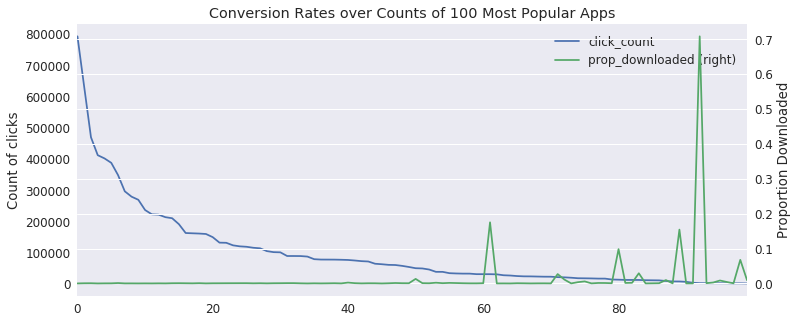

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      245       793105         0.000105
1      134       630888         0.000558
2      259       469845         0.000653
3      477       412559         0.000073
4      121       402226         0.000323
5      107       388035         0.000379
6      145       348862         0.001155
7      153       296832         0.000182
8      205       279720         0.000232
9      178       269720         0.000119
10     265       236949         0.000236
11     128       223205         0.000130
12     140       222096         0.000347
13     459       214060         0.000187
14     442       210687         0.000646
15     215       191618         0.000778
16     122       163312         0.000582
17     280       162425         0.000345
18     379       161608         0.000811
19     135       160215         0.000200


In [ ]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

There appear to be a few peaks for channels at reasonable click quantity, but overall the pattern holds same as for categories above.  

## BE CAREFUL about IPs as a signal

Vấn đề này được rất nhiều người bàn luận https://www.kaggle.com/yuliagm/be-careful-about-ips-as-a-signal

**Overall the number of IPs (test OR train): 333168**

**Number of IPs that are in both (test AND train): 38164**

**Number of IPs that are in Train and NOT in Test: 239232**

**Number of IPs that are in Test and NOT in Train: 55772**

Điều đó có nghĩa là có hơn một nửa số địa chỉ IP trong tập kiểm thử không tuân theo quy tắc ánh xạ của dữ liệu đào tạo.

Do đó, tôi nghĩ chúng ta cần phải cẩn trọng trong quá trình xác thực. Mô hình gán IP trong tập đào tạo không giống với mô hình trong tập kiểm thử. Nếu bạn sử dụng giá trị IP như một tín hiệu trong tập đào tạo, kết quả kiểm thử cuối cùng của bạn có thể bị sai lệch một cách đáng kể.

Dựa trên tập tin train_sample.csv và các mẫu con của tôi (tôi chưa thể chạy kiểm thử trên toàn bộ tập dữ liệu đào tạo), dường như có mối liên kết mạnh mẽ giữa các địa chỉ IP có số thấp và số lượt nhấp cao. Nói cách khác, các số trong khoảng từ 1 đến 125,000 có số lượt nhấp đáng kể nhiều hơn so với các địa chỉ IP trong khoảng từ 300,000 trở lên. Hầu như như là khi các giá trị IP được tạo ra để che giấu các IP thực, dữ liệu đã được sắp xếp trước theo số lượt nhấp trên mỗi IP, chia thành một số lớn nhóm chính. (Ví dụ, họ có thể đã thu thập nhóm phổ biến nhất và gán số từ 1 đến 125,000, sau đó nhóm tiếp theo và một khối số khác, và sau đó tiếp tục như vậy). Tôi nhận thấy khoảng 4 dải tần số khác nhau.

Điều đó có nghĩa là có hơn một nửa số địa chỉ IP trong tập kiểm thử không tuân theo quy tắc ánh xạ của dữ liệu đào tạo.

Do đó, tôi nghĩ chúng ta cần phải cẩn trọng trong quá trình xác thực. Mô hình gán IP trong tập đào tạo không giống với mô hình trong tập kiểm thử. Nếu bạn sử dụng giá trị IP như một tín hiệu trong tập đào tạo, kết quả kiểm thử cuối cùng của bạn có thể bị sai lệch một cách đáng kể.

See below for visualization based on Train subsample and full Test data



Let's now look at the downlad rate per ip in the train data.

In [ ]:
df = train.groupby('ip').is_attributed.mean().to_frame().reset_index()

df.head()

,ip,is_attributed
0,1,0.191489
1,5,0.000000
2,6,0.001376
3,9,0.001489
4,10,0.002542


One way to display numeric data and spot trend is to use a moving average. Let's try it here.



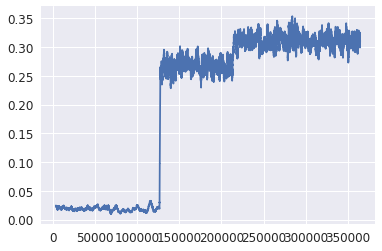

In [ ]:
df['roll'] = df.is_attributed.rolling(window=1000).mean()
plt.plot(df.ip, df.roll)
plt.figure(figsize=(90000,100000))
plt.show()

There is a clear cut split around 130,000, and a lighter split around 220,000. Below the first split ip have about 0.02 app download rate, then the rate climbs above 0.25. This is a 10x increase, worth eploring further.

A little trial and error leads to an identification of where the split is.

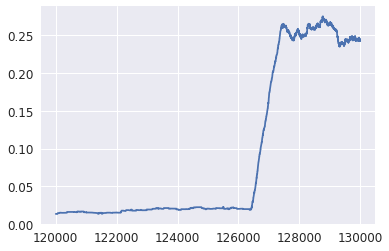

In [ ]:
df1 = df[(df.ip >= 120000) & (df.ip <= 130000)]
plt.plot(df1.ip, df1.roll)

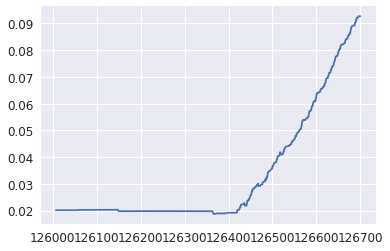

In [ ]:
df1 = df[(df.ip >= 126000) & (df.ip <= 126700)]
plt.plot(df1.ip, df1.roll)

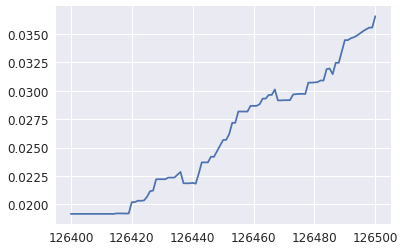

In [ ]:
df1 = df[(df.ip >= 126400) & (df.ip <= 126500)]
plt.plot(df1.ip, df1.roll)

The rate starts to climb at 126420.

Let's now look at where the ips present in test are compared to that split:

In [ ]:
test.ip.max()

126413

All the test ip are below the split!  In summary, numeric IP codes are informative in the training data but not in the test data, so you have to be careful with validation.

Another discussion said that The IP codes were apparently assigned starting with the test day. There is a "false leak" ("false leak" refers to a misleading or deceptive pattern in the data that might be misinterpreted as a genuine signal or relationship. It's a situation where certain patterns or correlations appear to exist, but they are not reflective of the true nature of the data or the underlying processes) in the sense I meant, but it is entirely false. Do not use numerical IP codes as a feature. (You can use IP codes if you hide the original numerical order, e.g., by frequency encoding, target encoding, one-hot encoding, just assigning arbitrary random new codes, or using a model that ignores the order.) Other than that, there's nothing you really need to know.

Source: https://www.kaggle.com/code/its7171/ip-encoding-looks-ok-data-is-clean/notebook

Round the click time down to an hour of the day to see if there are any hourly patterns.

For this part cannot use the first n rows from train data, as it's organized by time. To get a genral idea for the pattern, will use train data from the randomly sampled 100000 train set provided by organizers.

In [ ]:
train.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0


In [ ]:
#convert click_time and attributed_time to time series
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

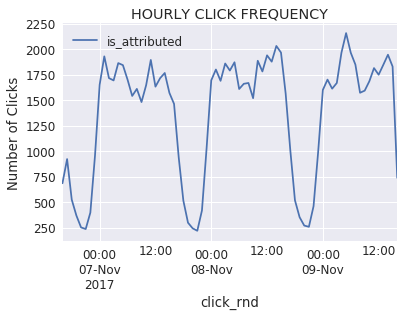

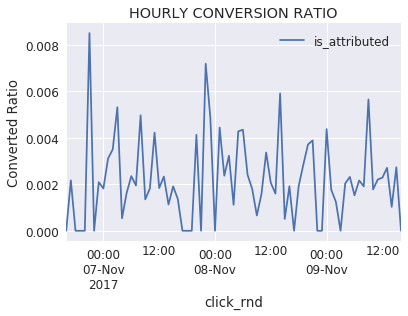

In [ ]:
#round the time to nearest hour
train['click_rnd']=train['click_time'].dt.round('H')  

#check for hourly patterns
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.

Lets extract the hour of day from each day as a separate feature, and see combined trend (merge the 4 days together by hour).

In [ ]:
#extract hour as a feature
train['click_hour']=train['click_time'].dt.hour

In [ ]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9


Let's check number of clicks by hour:

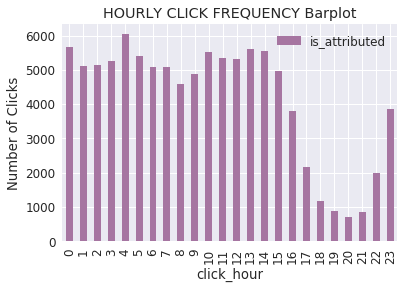

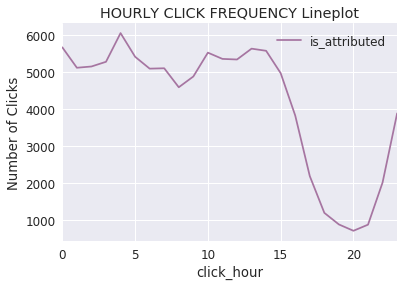

In [ ]:
# train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
# plt.title('HOURLY CLICK FREQUENCY Barplot');
# plt.ylabel('Number of Clicks');

# train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
# plt.title('HOURLY CLICK FREQUENCY Lineplot');
# plt.ylabel('Number of Clicks');

Chúng ta có thể thấy rằng số lượt nhấp chuột cao từ 0 giờ sáng đến 3 giờ chiều và sau 8 giờ chiều.

And number of conversions by hours:

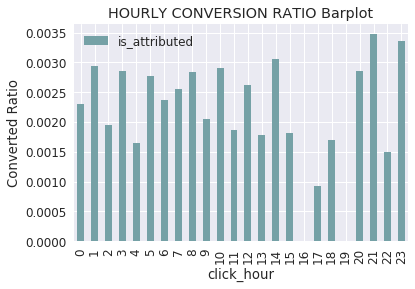

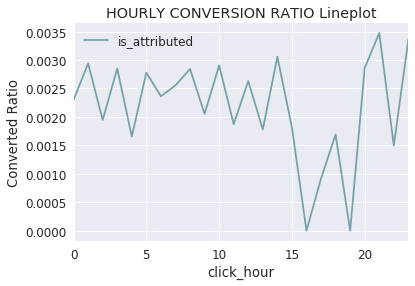

In [ ]:
# train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
# plt.title('HOURLY CONVERSION RATIO Barplot');
# plt.ylabel('Converted Ratio');

# train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
# plt.title('HOURLY CONVERSION RATIO Lineplot');
# plt.ylabel('Converted Ratio');

let's overlay the two graphs to see if patterns correlate in any way

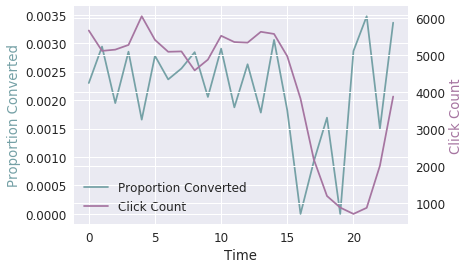

In [ ]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

The proportions may be more reliable if estimated on full data.  With the random sample it's  hard too tell because the variability is too high, especially for the hours with low click counts.   i.e. the fewer clicks/conversions, the wider margin of the estimated conversion ratio.  (see below)

### Look into attributed_time
Sau cú click ad bao lâu thì app được download?

In [ ]:
train['timePass']= train['attributed_time']-train['click_time']
#check:
train[train['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [ ]:
train['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

**Trong tập dữ liệu sample này có thể thấy khoảng thời gian chênh lệch lâu nhất giữa click và download là gần 13h, thấp nhất là khoảng 2s**

Việc chỉ mất 2 giây có vẻ quá nhanh để đưa ra quyết định. Người này có thể đã thấy quảng cáo trước đó, hoặc đã biết về sản phẩm thông qua cách khác nào đó.

Điều này có nghĩa là quảng cáo có thể đã được nhấp nhiều lần, nhưng chỉ có một lần được tính là chuyển đổi? Hoặc người đó đã nhấp vào quảng cáo với ý định tải xuống? (ví dụ: nếu kênh là một công cụ tìm kiếm như Google, quảng cáo có thể đã được nhấp trong quá trình xem kết quả tìm kiếm và ứng dụng được tải xuống ngay lập tức vì đó là điều người đó muốn làm ngay lập tức). Hoặc có thể đó là 1 con bot (Cần kiểm tra các dấu hiệu của hoạt động giả mạo, như các hành vi lặp lại từ cùng một IP hoặc thiết bị)?

### Check actual train data (the first 10,000,000)
double check the same feature on the first 10 million rows of train data:

In [ ]:
#check first 10,000,000 of actual train data
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

**Ở đây, thời gian tối thiểu từ khi nhấp chuột đến khi tải xuống gần như ngay lập tức. Làm thế nào điều này có thể xảy ra? Rõ ràng, đây không phải là kết quả của một quyết định của con người được thực hiện từ việc nhấp vào một quảng cáo được nhìn thấy lần đầu. Điều này dẫn đến 2 trường hợp là người đó biết nội dung quảng cáo hoặc đây là bot**